## Part Five Homography + RANSAC
1. Load im01.jpg and im02.jpg. Based on SIFT, find matches between the two images. Show all the matches.

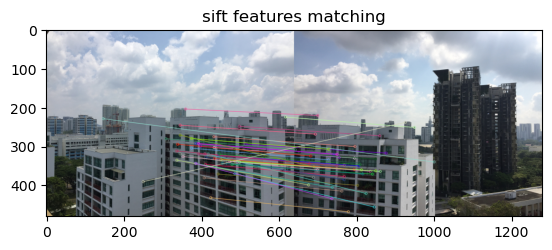

In [31]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

def sort_by_distance(pts1, pts2):
    "calculate and sort the distances between p1 and p2 matching points"
    res = []
    distance = np.zeros((len(pts1), len(pts2)))
    for i in range(len(pts1)): # [keypoints, descriptors]
        for j in range(len(pts2)):
            des1 = pts1[i][1]   # np array
            des2 = pts2[j][1]
            dist = np.sqrt(np.sum(np.square(des1 - des2)))  # Euclidian distance
            distance[i,j] = dist
            
    row_min, col_min = list(), list()
    
    for row in range(distance.shape[0]):
        temp = distance[row].tolist()
        idx = temp.index(min(temp))
        row_min.append([row, idx])  # minimum for each row

    for col in range(distance.shape[1]):
        temp = distance[:,col].tolist()
        idx = temp.index(min(temp))
        col_min.append([idx, col])  # minimum for each colume
    
    for r in range(len(row_min)):
        for c in range(len(col_min)):
            if row_min[r] == col_min[c]:
                temp = cv2.DMatch(_distance=distance[r,c],_trainIdx=c,_queryIdx=r)
                res.append(temp)
    res.sort(key=lambda x: x.distance)
    return res  # sorted by distance from min to max


# reading the image
img1 = cv2.imread('im01.jpg')
img2 = cv2.imread("im02.jpg")

# create SIFT feature extractor
sift = cv2.SIFT_create()
# detect features from the image
keypoints1, descriptors1 = sift.detectAndCompute(img1, None)
keypoints2, descriptors2 = sift.detectAndCompute(img2, None)

# matching with brute force
points1 = list(zip(keypoints1, descriptors1))
points2 = list(zip(keypoints2, descriptors2))

matched = sort_by_distance(points1, points2)
# print(matched)
res = cv2.drawMatches(img1,keypoints1,img2,keypoints2,matched[:50],None,flags=2)
res = cv2.cvtColor(res, cv2.COLOR_BGR2RGB)

plt.imshow(res)
plt.title("sift features matching")
plt.show()

2. Compute the best homography matrix using RANSAC, and show all the inlier matches (matches that support your best homography matrix)

In [52]:
import random
import math

def get_axis(pair):
    "get the coordiantes for the given keypoints"
    p2 = pair.trainIdx
    p1 = pair.queryIdx
    kp1 = np.array(keypoints1[p1].pt)
    kp2 = np.array(keypoints2[p2].pt)
    return kp1, kp2

def random_select(pairs):
    "randomly select keypoints from the matched key point set"
    res1, res2 = list(), list()
    rand_list = []
    i = 0
    while i < 4:
        rand = random.randint(0, len(pairs)-1)
        if rand in rand_list:
            continue
        rand_list.append(rand)
        pair = pairs[rand]
        kp1,kp2 = get_axis(pair)
        res1.append(kp1)
        res2.append(kp2)
        i+=1
    # print(rand_list)
    # print("res1:",res1,"\nres2:",res2)
    return res1, res2

def get_min_max(x,y,m):
    "get the minimum and maximum values of x and y"
    xmin,xmax,ymin,ymax = m
    if x < xmin:
        xmin = x
    elif x > xmax:
        xmax = x
    if y < ymin:
        ymin = y
    elif y > xmax:
        ymax = y
    return xmin,xmax,ymin,ymax

def trans(H, i1, i2):
    "transform the colored picture i1 to plane of i2"
    s1 = i1.shape
    s2 = i2.shape
    shape = (1200,1500,3)
    result = np.zeros(shape, dtype=i1.dtype)    # create the black canvas
    print(type(result[0,0]))
    row, col = np.shape(i1)[:2]
    xmin,xmax,ymin,ymax = 0,0,0,0
    temp1 = list()
    temp2 = list()
    i = 0
    while i < row:
        j = 0
        while j < col:
            t = np.matrix([j,i,1]).reshape(3,1)
            res = H.dot(t)
            res /= res[2,0]
            x = round(res[0,0])
            y = round(res[1,0])
            xmin,xmax,ymin,ymax = get_min_max(x,y,[xmin,xmax,ymin,ymax])
            # print(i,j)
            temp1.append([y,x,i1[int(i),int(j),:]])
            # temp2.append([int(i),int(j),i2[int(i),int(j),:]])
            j += 0.3
        i += 0.3
    # print(xmin,xmax,ymin,ymax)

    for t in temp1:
        if ymin < 0:
            y = t[0]-ymin
        elif ymax > shape[0]:
            y = t[0]-ymax
        if xmin < 0:
            x = t[1]-xmin
        elif xmax > shape[1]:
            x = t[1]-xmax
        result[y,x] = t[2]

    i = 0
    while i < row:
        j = 0
        while j < col:
            if result[i-ymin,j-xmin].tolist() != result[0,0].tolist():
                result[i-ymin,j-xmin] = list(map(lambda x: (x[0]+x[1]), zip(i2[i,j,:]/2, result[i-ymin,j-xmin]/2)))
            else:
                result[i-ymin,j-xmin] = i2[i,j,:]
            j += 1
        i += 1

    final = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
    return final 

def generate_A(points1, points2):
    x1, y1 = points1[0]
    x2, y2 = points1[1]
    x3, y3 = points1[2]
    x4, y4 = points1[3]
    x1_, y1_ = points2[0]
    x2_, y2_ = points2[1]
    x3_, y3_ = points2[2]
    x4_, y4_ = points2[3]
    
    A = np.matrix([[x1, y1, 1, 0, 0, 0, -x1*x1_, -y1*x1_, -x1_],
                [0, 0, 0, x1, y1, 1, -x1*y1_, -y1*y1_, -y1_],
                
                [x2, y2, 1, 0, 0, 0, -x2*x2_, -y2*x2_, -x2_],
                [0, 0, 0, x2, y2, 1, -x2*y2_, -y2*y2_, -y2_],
                
                [x3, y3, 1, 0, 0, 0, -x3*x3_, -y3*x3_, -x3_],
                [0, 0, 0, x3, y3, 1, -x3*y3_, -y3*y3_, -y3_],
                
                [x4, y4, 1, 0, 0, 0, -x4*x4_, -y4*x4_, -x4_],
                [0, 0, 0, x4, y4, 1, -x4*y4_, -y4*y4_, -y4_]])
    return A

def Homography(A):
    "do svd to matrix A and get the homography matrix"
    A = A/1.0
    _, _, V = np.linalg.svd(A)
    H1 = V[-1].reshape(3,3)
    H1  = H1/H1[2,2]
    return H1

def calc_single(point, H):
    "calculate the transformed axis for a single point"
    temp = np.array([point[0], point[1], 1]).reshape(3,1)
    calc = H.dot(temp).reshape(1,3)
    calc /= calc[0,2]
    # print(calc)
    return np.array([calc[0,0],calc[0,1]])

def ransac(iteration, matched, threshold, p):
    "find the best homography matrix"
    all_pairs = []
    for i in range(len(matched)):
        p1,p2 = get_axis(matched[i])
        all_pairs.append([p1,p2])  # p1 p2 are np.arrays (x,y)
    max_cnt = 0
    max_H = None
    i = 0

    while i < iteration:
        pts1, pts2 = random_select(matched) # coodinates for random selected 4 pairs of keypoints
        H = Homography(generate_A(pts1, pts2))
        cnt = 0
        inliers = []
        for pt1,pt2 in all_pairs:
            calc = calc_single(pt1, H)
            compare = np.array(pt2)
            dist = np.sqrt(np.sum(np.square(calc - compare)))
            # print(f"dist: {dist}\n p1: {pt1}\n Hp1: {calc}\n p2: {pt2}")
            if dist < threshold:
                inliers.append([pt1,pt2])
                cnt = cnt + 1
        
        if cnt > max_cnt:
            max_H = H
            max_cnt = cnt
            # print("iteration: {}, max count: {}".format(i,max_cnt))
        i += 1
        iteration = math.log(1 - p) / math.log(1 - pow(max_cnt / len(matched), 2))    # early convergence
        
    return max_H, max_cnt
    

In [53]:
if __name__ == "__main__":
    iteration = 0
    img1 = cv2.imread('im01.jpg')
    img2 = cv2.imread("im02.jpg")
    H, cnt = ransac(iteration=1000, matched=matched, threshold=2, p=0.995)
    # the max iteration num, matched points, theshold for inliers, p is the confidence probability
    print(f"The best homography matrix for img1 to img2 is\n{H}\n with {cnt} inliers")
            

        

The best homography matrix for img1 to img2 is
[[ 1.83857969e+00 -1.31420548e-02 -5.54060034e+02]
 [ 4.18590626e-01  1.54267856e+00 -1.35921358e+02]
 [ 1.51701049e-03 -3.32997056e-04  1.00000000e+00]]
 with 51 inliers


3. Stitch the images together using the best homography matrix and show the result

<class 'numpy.ndarray'>


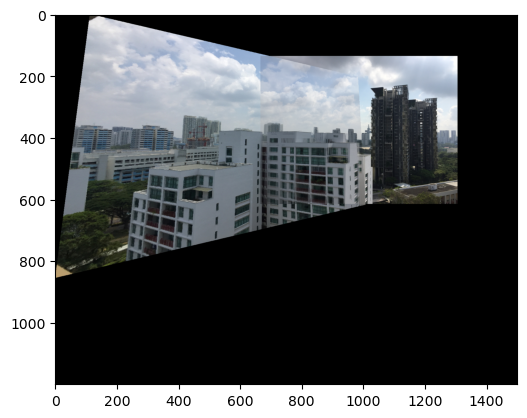

In [54]:
final = trans(H,img1,img2)
plt.imshow(final, vmin=0, vmax=255)